In [52]:
import os
import nltk
import tweepy
from dotenv import load_dotenv
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
import re
import cv2
import numpy as np
import pandas as pd
import pickle
# NOTE: THE WORDCLOUD PACKAGE ISN'T WORKING FOR SOME VERSIONS OF PYTHON.
# LOCKING PYTHON VERSION TO 3.7 BECAUSE OF THAT.
from wordcloud import WordCloud

In [53]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

In [54]:
load_dotenv()
TWITTER_BEARER_TOKEN = os.getenv('TWITTER_BEARER_TOKEN')
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [55]:
print("Authenticating to Twitter...")

client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, wait_on_rate_limit=True)
auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

Authenticating to Twitter...


In [56]:
twitter_russia_sources_rus_usernames = ["@1tvru_news", "@ru_rbc",
                                         "@er_novosti",
                              "@rt_com",
                              "@medvedevrussia", "@kremlinrussia",
                              "@rentvchannel", "@vesti_news", "@kpru"]

twitter_ukraine_sources_rus_usernames = ["@dmitry_gordon", "@SvobodaRadio",
                               "@euronewsru", "@FeyginMark4", "@tvrain", "@teamnavalny"]

twitter_ukraine_sources_ukr_usernames = ["@HromadskeUA", "@tsnua", "@24tvua", "@unian",
                               "@radiosvoboda", "@5channel", "@EspresoTV"]

twitter_ukraine_sources_eng_usernames = ["@mschwirtz", "@KyivIndependent", "@KyivPost",
                               "@mchancecnn", "@fpleitgenCNN", "@Kasparov63",
                               "@ikhurshudyan", "@myroslavapetsa",
                               "@langfittnpr", "@ElBeardsley", "@timkmak"]

https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

In [57]:
def get_user_id_from_username(username):
    user = api.get_user(screen_name=username)
    return user.id

In [58]:
russia_sources_rus = []
ukraine_sources_rus = []
ukraine_sources_ukr = []
ukraine_sources_eng = []

In [59]:
LOAD_CLUSTERS_DATA = True

In [60]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_russia_sources_rus_usernames:
        russia_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_rus_usernames:
        ukraine_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_ukr_usernames:
        ukraine_sources_ukr.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_eng_usernames:
        ukraine_sources_eng.append((username, get_user_id_from_username(username)))

In [61]:
if not LOAD_CLUSTERS_DATA:
    russia_sources_rus_pickled = pickle.dumps(russia_sources_rus)
    ukraine_sources_rus_pickled = pickle.dumps(ukraine_sources_rus)
    ukraine_sources_ukr_pickled = pickle.dumps(ukraine_sources_ukr)
    ukraine_sources_eng_pickled = pickle.dumps(ukraine_sources_eng)

In [62]:
CLUSTERS_SERIALIZATION_DIR = "data_clusters/"

In [63]:
if not LOAD_CLUSTERS_DATA:
    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle', 'wb') as f:
        f.write(russia_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_ukr_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled.pickle','wb') as f:
        f.write(ukraine_sources_eng_pickled)

In [64]:
if LOAD_CLUSTERS_DATA:
    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle',\
            'rb') as f:
        russia_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_ukr = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_eng = pickle.load(f)

In [65]:
def get_user_followers(user_name, user_id, num_pages=1):
    followers = []
    # User rate limit (User context): 15 requests per 15-minute window per each authenticated user
    # limit – Maximum number of requests to make to the API
    # max_results : The maximum number of results to be returned per page. This can be a number between 1 and the 1000. By default, each page will return 100 results.
    # I.E. 15 000 followers can be returned in 15 minutes
    followers_paginator = tweepy.Paginator(client.get_users_followers, id =
    user_id, max_results = 1000, limit = num_pages).flatten()
    for follower in followers_paginator:
        followers.append(follower)
    return (user_name, user_id), followers

In [66]:
def get_user_follower_count(user_id):
    # fetching the user
    user = api.get_user(user_id = user_id)
    return user.followers_count

In [67]:
rus_cluster_followers = []
ukr_eng_cluster_followers = []
ukr_rus_cluster_followers = []
ukr_ukr_cluster_followers = []

In [68]:
# PRODUCTION CODE
# get 105 000 followers per cluster: 1:45 min per cluster, 105 requests

'''
for cluster in russia_sources_rus:
    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_rus:
    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_ukr:
    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_eng:
    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))
'''

'\nfor cluster in russia_sources_rus:\n    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_rus:\n    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_ukr:\n    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_eng:\n    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n'

In [69]:
# TEST CODE: 1000 followers per cluster, 2 cluster per each
for i in range(0, 2):
    rus_cluster_followers.append(get_user_followers(russia_sources_rus[i][0],                                               russia_sources_rus[i][1]))

for i in range(0, 2):
    ukr_eng_cluster_followers.append(get_user_followers(ukraine_sources_rus[i][0],                                               ukraine_sources_rus[i][1]))

In [70]:
print(ukr_eng_cluster_followers)

[(('@dmitry_gordon', 1334400780), [<User id=1591395490117128194 name=VirTool_Net username=VirTool_Net>, <User id=1597441742227345410 name=Лариса Костикова username=kostikovalori>, <User id=1598680065411358721 name=mubariz username=mubariz82340874>, <User id=1598697494556327936 name=Sergei username=Sergei39084012>, <User id=1598696697303121920 name=костян username=kostn07735284>, <User id=1598688591848374272 name=Eldar username=letimsk>, <User id=1598692200681963522 name=Lesha Zelentsov username=LeshaZelentsov>, <User id=1584568412063268865 name=Chef username=RussellUK123>, <User id=1598688990491820034 name=Sahil username=Sahil700700>, <User id=1598686577802215424 name=evgeni username=evgeni35387570>, <User id=1598680856612200449 name=pavel kotorobai username=PavelKotorobai>, <User id=1598683451204460545 name=Otar Karkusov username=_bk_6_6>, <User id=1497945517988401159 name=Ivana Tomášková username=tomaskova_ivana>, <User id=1503770633406193664 name=Zhanneta Fooksman username=ZFooksman

In [71]:
'''
print(type(followers[('@minregion_ua', 3333475643)][0]))
print(followers[('@minregion_ua', 3333475643)][0].name)
print(followers[('@minregion_ua', 3333475643)][0].id)
'''

"\nprint(type(followers[('@minregion_ua', 3333475643)][0]))\nprint(followers[('@minregion_ua', 3333475643)][0].name)\nprint(followers[('@minregion_ua', 3333475643)][0].id)\n"

In [72]:
CLUSTER_IDX = 0
FOLLOWER_IDX = 1

rus_cluster = {}
ukr_eng_cluster = {}
ukr_rus_cluster = {}
ukr_ukr_cluster = {}

In [73]:
def cluster_to_df(cluster_list):

    cluster_dfs = {}

    for cluster in cluster_list:
        follower_names = [follower.name for follower in cluster[FOLLOWER_IDX]]
        follower_ids = [follower.id for follower in cluster[FOLLOWER_IDX]]
        followers_data = {
            'username': follower_names,
            'user_id': follower_ids
        }
        cluster_dfs[cluster[CLUSTER_IDX]] = pd.DataFrame(followers_data)

    return cluster_dfs

In [74]:
rus_cluster = cluster_to_df(rus_cluster_followers)
ukr_eng_cluster = cluster_to_df(ukr_eng_cluster_followers)
ukr_rus_cluster = cluster_to_df(ukr_rus_cluster_followers)
ukr_ukr_cluster = cluster_to_df(ukr_ukr_cluster_followers)

In [75]:
# this fucntion converts a list of cluster centers and their followers to csv
# files
CLUSTERS_DIR = "clusters/"

def clusters_to_files(clusters_df):
    for cluster_center, cluster_followers in clusters_df.items():
        cluster_csv = cluster_followers.to_csv()
        with open(CLUSTERS_DIR + cluster_center[CLUSTER_IDX][1:] + '_' + str(cluster_center[FOLLOWER_IDX]) + '.csv',
                  'w') as f:
            f.write(cluster_csv)

In [76]:
clusters_to_files(rus_cluster)
clusters_to_files(ukr_eng_cluster)

<h2>Visualizing Connections as a Graph</h2>

In [77]:
ukr_eng_cluster[('@dmitry_gordon',
  1334400780)]

,username,user_id
0,VirTool_Net,1591395490117128194
1,Лариса Костикова,1597441742227345410
2,mubariz,1598680065411358721
3,Sergei,1598697494556327936
4,костян,1598696697303121920
...,...,...
994,Stanislav Zimin,1595370878853939200
995,Vytas Macevicius,1583494257788297217
996,Клинцов Сергей,2824673485
997,Дима Шаповал,1595236558281605120


In [78]:
import networkx as nx

In [79]:
print("Creating a DataFrame containing the complete graph")

GROUP_ID_MAP = {
    "rus_cluster": 0,
    "ukr_eng_cluster": 1,
    "ukr_rus_cluster": 2,
    "ukr_ukr_cluster": 3
}

global_graph_pd = pd.DataFrame(columns=['username', 'user_id',
                                     'cluster_name', 'cluster_id',
                                     'cluster_follow_count', 'group_id'])

Creating a DataFrame containing the complete graph


In [80]:
def add_cluster_to_global_graph(cluster, group_name, graph_pd):
    curr_cluster_df = pd.DataFrame()
    for cluster_center, cluster_followers in cluster.items():
        curr_cluster_df = cluster_followers.copy(deep=True)
        curr_cluster_df.insert(2, "cluster_name", cluster_center[0])
        curr_cluster_df.insert(3, "cluster_id", int(cluster_center[1]))
        curr_cluster_df.insert(4, "cluster_follow_count",
                               get_user_follower_count(cluster_center[1]),
                               True)
        curr_cluster_df.insert(5, "group_id", GROUP_ID_MAP[group_name])
    return pd.concat([graph_pd, curr_cluster_df])

In [81]:
def save_image(img, img_name):
    IMG_DIR = "visualizations/"
    plt.imsave(IMG_DIR + img_name, img)

In [82]:
global_graph_pd = add_cluster_to_global_graph(rus_cluster, "rus_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_eng_cluster, "ukr_eng_cluster",
                                              global_graph_pd)

In [83]:
print(global_graph_pd.size)
print(set(global_graph_pd['cluster_name']))

12000
{'@ru_rbc', '@SvobodaRadio'}


In [84]:
global_graph_pd_columns = list(global_graph_pd.columns)

In [85]:
print("Constructing NetworkX graph")

# what if you store all attributes as edge attributes?
G = nx.from_pandas_edgelist(global_graph_pd, source='username',
                            target='cluster_name', edge_attr = global_graph_pd_columns,
                             create_using=nx.DiGraph())

pos = nx.spring_layout(G)

Constructing NetworkX graph


Visualizing a small subset of connections...


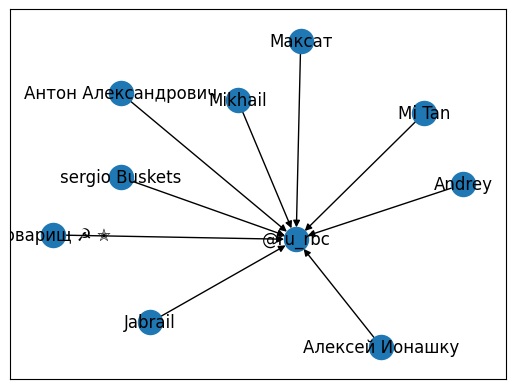

In [86]:
print("Visualizing a small subset of connections...")

subgraph = G.subgraph(list(G.nodes)[:10])

subgraph_pos = nx.spring_layout(subgraph)

nx.draw_networkx(subgraph, subgraph_pos)

<h2>Network Anslysis Questions:</h2>

1. How many connections are overlapping within each given group. (e.g. how
many people following SWJ also follow NYT)
2. How many overlaps are there in between clusters from different groups?

3. Do nodes cluster into tightly connected groups?

<h2>Network Visualization Questions</h2>

3. Visualize the connections in pretty way
4. Visualize Cluster sizes
5. Visualize groups by color coding them

<h2>Sentiment Analysis Questions</h2>
1. Word Cloud: what are people within each group discussing (Use entity recognition)?

2. Tag Cloud: who are people within each group discussing?

3. What sentiment do mentions within each groups have?

4. What is a general Twitter sentiment on this topic (Can use Ukraine dataset)

<h2>Visualization Techniques that can be leveraged</h2>
1. Network Visualization

2. Coloring nodes

3. Coloring Connections

4. Size of the nodes

5. Shape of the nodes


In [87]:
def get_edge_attributes(graph, attr_list):
    KEY = 0
    VALUE = 1
    edge_attrs = {}
    for attr in attr_list:
        edges_attribute = nx.get_edge_attributes(graph, attr)
        for edge_attr in edges_attribute.items():
            if edge_attr[KEY] in edge_attrs.keys():
                edge_attr_values = edge_attrs[edge_attr[KEY]]
                edge_attr_values.append(edge_attr[VALUE])
                edge_attrs[edge_attr[KEY]] = edge_attr_values
            else:
                edge_attrs[edge_attr[KEY]] = [edge_attr[VALUE]]
    return edge_attrs

edge_attrs = get_edge_attributes(subgraph, global_graph_pd_columns)

print(edge_attrs)

{('Алексей Ионашку', '@ru_rbc'): ['Алексей Ионашку', 1598698949040345088, '@ru_rbc', 269770723, 535731, 0], ('Антон Александрович', '@ru_rbc'): ['Антон Александрович', 1598696350052499459, '@ru_rbc', 269770723, 535731, 0], ('Максат', '@ru_rbc'): ['Максат', 1598706159984283651, '@ru_rbc', 269770723, 535731, 0], ('Jabrail', '@ru_rbc'): ['Jabrail', 1597651005684027392, '@ru_rbc', 269770723, 535731, 0], ('sergio Buskets', '@ru_rbc'): ['sergio Buskets', 895734405502652416, '@ru_rbc', 269770723, 535731, 0], ('Mi Tan', '@ru_rbc'): ['Mi Tan', 762561215054970880, '@ru_rbc', 269770723, 535731, 0], ('Andrey', '@ru_rbc'): ['Andrey', 577110950, '@ru_rbc', 269770723, 535731, 0], ('Mikhail', '@ru_rbc'): ['Mikhail', 1597753746817273856, '@ru_rbc', 269770723, 535731, 0], ('товарищ ☭ ✭', '@ru_rbc'): ['товарищ ☭ ✭', 1458742682361245696, '@ru_rbc', 269770723, 535731, 0]}


In [88]:
print("Running analysis on the network...")

# https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781789955316/7

Running analysis on the network...


In [89]:
import networkx.algorithms.community as nxcom

# identifying communities within the network
twitter_communities = sorted(nxcom.greedy_modularity_communities(G), key=len,
                             reverse=True)

In [90]:
print("The number of communities detected is ", len(twitter_communities))

The number of communities detected is  2


In [91]:
print("Visualizing Identified Communities")

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

Visualizing Identified Communities


In [92]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [93]:
# Set node and edge communities
set_node_community(G, twitter_communities)
set_edge_community(G)

# Set community color for nodes
node_color = [
    get_color(G.nodes[v]['community'])
    for v in G.nodes]

# Set community color for internal edges
external = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] == 0]

internal = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] > 0]

internal_color = [
    get_color(G.edges[e]['community'])
    for e in internal]

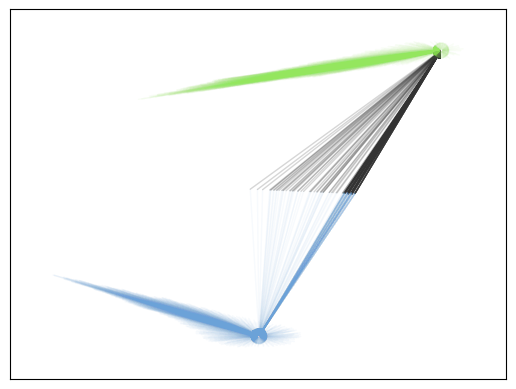

In [94]:
# Draw external edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=external, edge_color="#333333",
    alpha=0.2, with_labels=False)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=False)

In [95]:
all_clusters = []

all_clusters.extend(rus_cluster)
all_clusters.extend(ukr_eng_cluster)
all_clusters.extend(ukr_rus_cluster)
all_clusters.extend(ukr_ukr_cluster)

all_clusters_dict = {}

for cluster in all_clusters:
    if str(cluster[0]) in G.nodes:
        all_clusters_dict[str(cluster[0])] = str(cluster[0])

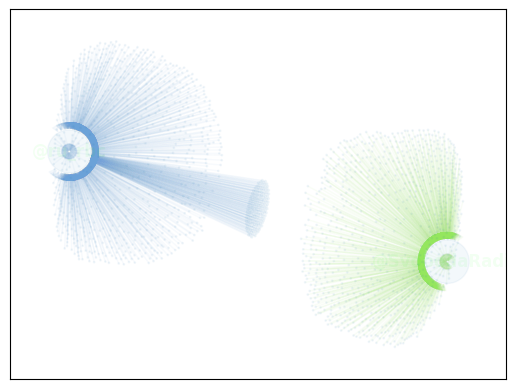

In [96]:
# TODO: ADD CLUSTER LABELS TO THE VISUALIZATION BELOW
pos = nx.spring_layout(G, k=0.15)

G_node_degrees = dict(G.degree)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=[v * 1 for v in G_node_degrees.values()],
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=True, label='Group Follower Clusters',
    labels=all_clusters_dict, font_color='#00ff00', font_weight='bold')

In [97]:
def sort_graph_by_deg_desc(graph):
    return sorted(G.degree, key=lambda x: x[1], reverse=True)

In [98]:
G_deg_sorted = sort_graph_by_deg_desc(G)

In [99]:
print("Performing connectivity analysis on a graph")

node_connections = nx.all_pairs_node_connectivity(subgraph)

Performing connectivity analysis on a graph


In [100]:
def get_shared_nodes_within_group(node_connections, group_members):
    shared_connections = []
    for username, connections_dict in node_connections.items():
        for group_member in group_members:
            if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                shared_connections.append(username)
    return shared_connections

In [101]:
get_shared_nodes_within_group(node_connections, rus_cluster)

[]

In [102]:
def get_shared_nodes_between_groups(node_connections, cluster_groups):
    shared_connections = {}
    for username, connections_dict in node_connections.items():
        for group_name, group_members in cluster_groups.items():
            for group_member in group_members:
                if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                    if group_name not in shared_connections.keys():
                        shared_connections.append(username)
                    else:
                        shared_connections[group_name] = shared_connections[group_name].append(username)
    return shared_connections

In [103]:
TWITTER_CLUSTER_GROUPS = {
    "rus_cluster": russia_sources_rus,
    "ukr_eng_cluster": ukraine_sources_rus,
    "ukr_rus_cluster": ukraine_sources_ukr,
    "ukr_ukr_cluster": ukraine_sources_eng
}

In [104]:
shared_connections_between_groups = get_shared_nodes_between_groups\
(node_connections, TWITTER_CLUSTER_GROUPS)

In [105]:
shared_connections_between_groups

{}

In [106]:
'''
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
'''

"\nimport matplotlib.pyplot as plt\n\nf, ax = plt.subplots(figsize=(10, 10))\nplt.style.use('ggplot')\nnodes = nx.draw_networkx_nodes(G, pos,\n                               alpha=0.8)\nnodes.set_edgecolor('k')\nnx.draw_networkx_labels(G, pos, font_size=8)\nnx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)\n"

In [ ]:
# TODO: analyze social network graph using NetworkX
# TODO: perhaps the network should be cleaned of low degree connected users
#  for visualization purposes
# TODO: run the graph analytics on the original network w/o visualizing it

<h2>Visualizing the Network using Gephi</h2>

In [ ]:
# TODO: node size should correspond to the number of followers the node has
# TODO: node color should correspond to the node group

<h2>Visualizing the Network using Neo4j</h2>

<h2>Analyzing group sentiments</h2>

In [107]:
# NOTE: THIS FUNCTION PULLS THE TWEETS MENTIONING A PARTICULAR USER, NOT FROM
# A PARTICULAR USER

def get_user_tweet_mentions(username, num_tweets, entities=None):

    search_query = username + " OR "

    if entities is not None:
        # include all possible candidate names in a query
        for entity in entities:
            search_query += "entity:" + '"' + entity + '"' + " OR "

    # remove the last OR statement
    search_query = search_query[:-3]

    search_query += "-is:retweet"

    tweets = api.search_tweets(q = search_query, count = num_tweets,
                               tweet_mode="extended")

    return tweets

In [118]:
def get_user_tweets(user_id, num_tweets):

    # https://docs.tweepy.org/en/stable/client.html#tweepy.Client.get_users_tweets
    # https://docs.tweepy.org/en/stable/expansions_and_fields.html#expansions-parameter
    # https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

    tweets = client.get_users_tweets(id = user_id, max_results = num_tweets,
                               exclude = ['retweets'], expansions='entities.mentions.username')

    return tweets

In [119]:
# Sentiment in relation to a different group

# Tweets word Cloud

# Tweets HashTags Word Cloud

# Tweets events mapping? (Maybe)

In [120]:
# https://www.caida.org/catalog/software/walrus/

In [127]:
print("Pulling a sample of tweets for all clusters")

NUM_TWEETS = 5
USERNAME_IDX = 0
USER_ID_IDX = 1

cluster_tweets = {}

for cluster in all_clusters:
    cluster_tweets[cluster] = get_user_tweets(cluster[USER_ID_IDX], NUM_TWEETS)

Pulling a sample of tweets for all clusters


In [135]:
cluster_tweets

{('@1tvru_news',
  160881696): Response(data=[<Tweet id=1598670772301492225 text='Новый ракетный удар по мирным жителям Донецка. В сети публикуют момент атаки. Украинские боевики открыли огонь по многоэтажке. Прямое попадание реактивного снаряда. Взрывной волной выбило стекла в соседних зданиях. Два человека погибли https://t.co/xUgOmV4iWN https://t.co/hN8uLeHwzu'>, <Tweet id=1598626321202044928 text='Сегодня развитие получила история вокруг заявлений главы Еврокомиссии Урсулы фон дер Ляйен об огромных потерях среди украинских военных с начала СВО. И вот комментирует советник главы офиса Зеленского Михаил Подоляк. Кто лучше считает, Брюссель или Киев: https://t.co/NspV7XYEx6 https://t.co/XMB9Ft6sou'>, <Tweet id=1598619430019387393 text='В Минобороны России рассказали о новых подвигах военных на передовой: https://t.co/AduMUcPcQg https://t.co/Tzt4TcrcW7'>, <Tweet id=1598615313775562753 text='Кадры от Минобороны из зоны проведения спецоперации. В деле российские минометчики. Они наносят 

In [130]:
def convert_tweets_to_json(raw_tweets_dict):
    json_tweets = []
    for username, tweets in raw_tweets_dict.items():
        for tweet in tweets:
            json_tweet_str = json.dumps(tweet.text)
            json_tweet = json.loads(json_tweet_str)
            json_tweets.append(json_tweet)
    return json_tweets

In [218]:
tweet_status = api.get_status(1598709448129662977)

print(tweet_status._json)

{'created_at': 'Fri Dec 02 16:03:29 +0000 2022', 'id': 1598709448129662977, 'id_str': '1598709448129662977', 'text': 'На канале "В гостях у Гордона" транслируется стрим главного редактора интернет-издания "#ГОРДОН" Алеси #Бацман с те… https://t.co/ta77zbvZLc', 'truncated': True, 'entities': {'hashtags': [{'text': 'ГОРДОН', 'indices': [88, 95]}, {'text': 'Бацман', 'indices': [103, 110]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/ta77zbvZLc', 'expanded_url': 'https://twitter.com/i/web/status/1598709448129662977', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1334400780, 'id_str': '1334400780', 'name': 'Дмитрий Гордон', 'screen_name': 'dmitry_gordon', 'location': 'Украина', 'descri

In [236]:
cluster_tweets

{('@1tvru_news',
  160881696): Response(data=[<Tweet id=1598670772301492225 text='Новый ракетный удар по мирным жителям Донецка. В сети публикуют момент атаки. Украинские боевики открыли огонь по многоэтажке. Прямое попадание реактивного снаряда. Взрывной волной выбило стекла в соседних зданиях. Два человека погибли https://t.co/xUgOmV4iWN https://t.co/hN8uLeHwzu'>, <Tweet id=1598626321202044928 text='Сегодня развитие получила история вокруг заявлений главы Еврокомиссии Урсулы фон дер Ляйен об огромных потерях среди украинских военных с начала СВО. И вот комментирует советник главы офиса Зеленского Михаил Подоляк. Кто лучше считает, Брюссель или Киев: https://t.co/NspV7XYEx6 https://t.co/XMB9Ft6sou'>, <Tweet id=1598619430019387393 text='В Минобороны России рассказали о новых подвигах военных на передовой: https://t.co/AduMUcPcQg https://t.co/Tzt4TcrcW7'>, <Tweet id=1598615313775562753 text='Кадры от Минобороны из зоны проведения спецоперации. В деле российские минометчики. Они наносят 

In [243]:
TWEETS_DIR = 'tweets/'

def tweets_to_df(raw_tweets_dict):
    tweets_df = pd.DataFrame(
        {
            'Cluster Username' : pd.Series(dtype='str'),
            'Cluster ID' : pd.Series(dtype='int'),
            'Tweet Text' : pd.Series(dtype='str')
        }
    )
    for username, tweets in raw_tweets_dict.items():
            for tweet in tweets.data:
                new_df_row = {
                    'Cluster Username' : username[0],
                    'Cluster ID' : username[1],
                    'Tweet Text' : str(tweet)
                }
                tweets_df = tweets_df.append(new_df_row, ignore_index=True)
    return tweets_df

def tweets_df_to_csv(tweets_df):
    tweets_df.to_csv(TWEETS_DIR + 'tweets.csv', index=False)
    return

In [244]:
tweets_df = tweets_to_df(cluster_tweets)
tweets_df_to_csv(tweets_df)